# Project Title: Customer Sign-Up Behaviour & Data Quality Audit 

### Installing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from word2number import w2n

## Load & Clean the Data 

In [2]:
# Read the csv file
df = pd.read_csv('customer_signups.csv', encoding='unicode_escape')
df_original = df

#### a. Identify missing values, data types, and column structure

In [3]:
df.isnull().sum()

customer_id          2
name                 9
email               34
signup_date          2
source               9
region              30
plan_selected        8
marketing_opt_in    10
age                 12
gender               8
dtype: int64

In [4]:
Missing_percent = ((df.isnull().sum()/len(df))*100).round(2)
Missing_percent

customer_id          0.67
name                 3.00
email               11.33
signup_date          0.67
source               3.00
region              10.00
plan_selected        2.67
marketing_opt_in     3.33
age                  4.00
gender               2.67
dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       298 non-null    object
 1   name              291 non-null    object
 2   email             266 non-null    object
 3   signup_date       298 non-null    object
 4   source            291 non-null    object
 5   region            270 non-null    object
 6   plan_selected     292 non-null    object
 7   marketing_opt_in  290 non-null    object
 8   age               288 non-null    object
 9   gender            292 non-null    object
dtypes: object(10)
memory usage: 23.6+ KB


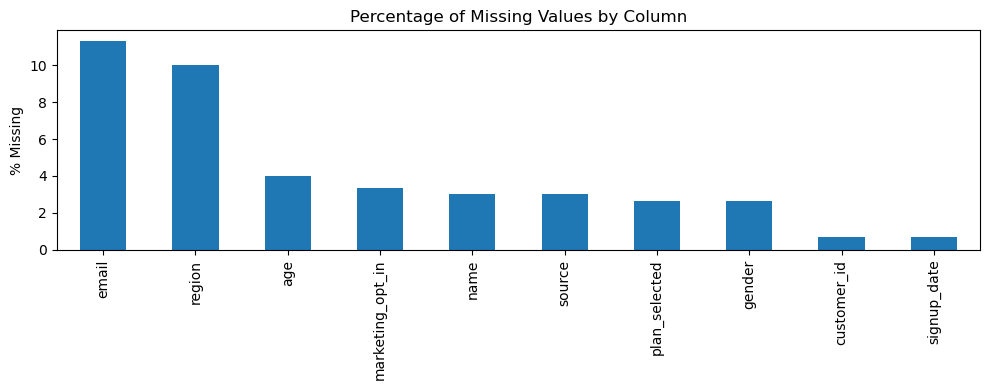

In [6]:
Missing_percent.sort_values(ascending=False).plot(kind='bar', figsize=(10,4))
plt.title('Percentage of Missing Values by Column')
plt.ylabel('% Missing')
plt.tight_layout()
plt.show()

In [7]:
df.columns

Index(['customer_id', 'name', 'email', 'signup_date', 'source', 'region',
       'plan_selected', 'marketing_opt_in', 'age', 'gender'],
      dtype='object')

#### b. Convert signup_date to datetime 

In [8]:
df['signup_date'] = df['signup_date'].astype(str)
df['signup_date']  = df['signup_date'].str.replace(r'(\d+)(st|nd|rd|th)',r'\1',regex=True)
df['signup_date'] = pd.to_datetime(df['signup_date'],errors='coerce')
#df['signup_date'] = df['signup_date'].dt.strftime('%d-%m-%Y')
df['signup_date'] 

C:\Users\shabn\AppData\Local\Temp\ipykernel_49376\518335588.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['signup_date'] = pd.to_datetime(df['signup_date'],errors='coerce')


0            NaT
1     2024-02-01
2     2024-03-01
3     2024-04-01
4     2024-05-01
         ...    
295   2024-10-22
296   2024-10-23
297   2024-10-24
298   2024-10-25
299   2024-10-26
Name: signup_date, Length: 300, dtype: datetime64[ns]

#### c. Standardise inconsistent text values (plan_selected, gender, etc.)

In [9]:
df['plan_selected'] = df['plan_selected'].str.capitalize().replace({'Prem':'Premium'})
df['plan_selected'].unique()

array(['Basic', 'Premium', 'Pro', 'Unknownplan', nan], dtype=object)

In [10]:
df['gender'] = df['gender'].str.capitalize()
df['gender'] = df['gender'].replace({'Non-binary' : 'Other'})
df['gender'] = df['gender'].replace({'123' : np.nan})
df['gender'].unique()

array(['Female', 'Male', 'Other', nan], dtype=object)

In [11]:
# Replacing unknown age to null values
df['age'] = df['age'].replace({'unknown' : np.nan})             
df['age'].unique()

array(['34', '29', '40', '25', '60', '47', '53', '21', nan, 'thirty',
       '206'], dtype=object)

In [12]:
#Replacing Nil values to No for 'marketing_opt_in' 
df['marketing_opt_in'] = df['marketing_opt_in'].replace({'Nil': 'No'})
df['marketing_opt_in'].unique()

array(['No', 'Yes', nan], dtype=object)

#### d. Remove duplicate rows based on customer_id

In [13]:
df = df.drop_duplicates(subset='customer_id', keep='first')
print("No. of rows and columns after deleting duplicate customers" , df.shape)
print(df.columns.tolist())

No. of rows and columns after deleting duplicate customers (299, 10)
['customer_id', 'name', 'email', 'signup_date', 'source', 'region', 'plan_selected', 'marketing_opt_in', 'age', 'gender']


#### e. Handle missing values (e.g., region, email, age) 

In [14]:
# Dropping the rows without customer ID
df=df[df['customer_id'].notna()]

# Replacing the blank values of email 
df['email'] =df['email'].fillna('unknown@example.com')

# Replacing null value of date with median
median_date = df['signup_date'].median()
df['signup_date'] = df['signup_date'].fillna(median_date)

# Replacing ?? and null values of Source with 'Unknown'
df['source'] = df['source'].replace('??','Unknown')
df['source'] = df['source'].fillna('Unknown')

# Replacing null value of region with 'Unknown'
df['region'] =df['region'].fillna('Unknown')

# Replacing null values of plan_selected with 'Unknownplan'
df['plan_selected'] = df['plan_selected'].fillna('Unknownplan')

#Replacing Null values of 'marketing_opt_in' with 'Unknown'
df['marketing_opt_in'] = df['marketing_opt_in'].fillna('Unknown')

# Replacing string format of age to number format
              
def clean_age(x):
    if pd.isna(x):
        return None
    x = str(x).strip().lower()
    if x.isdigit():
        return int(x)
    try:
        return w2n.word_to_num(x)
    except ValueError:
        return None

# Apply cleaning
df['age'] = df['age'].apply(clean_age)

# keep missing values as <NA> but still use integer dtype
df.loc[df['age'] > 100, 'age'] = pd.NA
df['age'] = df['age'].astype('Int64')

# Replacing null values in gender with 'Unknown'
df['gender'] = df['gender'].fillna('Unspecified')

In [15]:
df['age'].unique()

<IntegerArray>
[34, 29, 40, 25, 60, 47, 53, 21, <NA>, 30]
Length: 10, dtype: Int64

### 2. Data Quality Summary

#### a. Count of missing values per column 

In [16]:
df.isnull().sum()

customer_id          0
name                 9
email                0
signup_date          0
source               0
region               0
plan_selected        0
marketing_opt_in     0
age                 19
gender               0
dtype: int64

#### b. % of missing values 

In [17]:
Missing_percent_Clean = ((df.isnull().sum()/len(df))*100).round(2)
Missing_percent_Clean

customer_id         0.00
name                3.02
email               0.00
signup_date         0.00
source              0.00
region              0.00
plan_selected       0.00
marketing_opt_in    0.00
age                 6.38
gender              0.00
dtype: float64

#### c. Number of duplicates removed 

In [18]:
df = df.drop_duplicates(subset='customer_id', keep='first')
len(df)

298

In [19]:
df['source'].value_counts()

source
YouTube      58
Google       50
Referral     49
Instagram    48
Facebook     40
LinkedIn     38
Unknown      15
Name: count, dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298 entries, 0 to 299
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       298 non-null    object        
 1   name              289 non-null    object        
 2   email             298 non-null    object        
 3   signup_date       298 non-null    datetime64[ns]
 4   source            298 non-null    object        
 5   region            298 non-null    object        
 6   plan_selected     298 non-null    object        
 7   marketing_opt_in  298 non-null    object        
 8   age               279 non-null    Int64         
 9   gender            298 non-null    object        
dtypes: Int64(1), datetime64[ns](1), object(8)
memory usage: 25.9+ KB


### Summary Outputs (Using Pandas Aggregation)

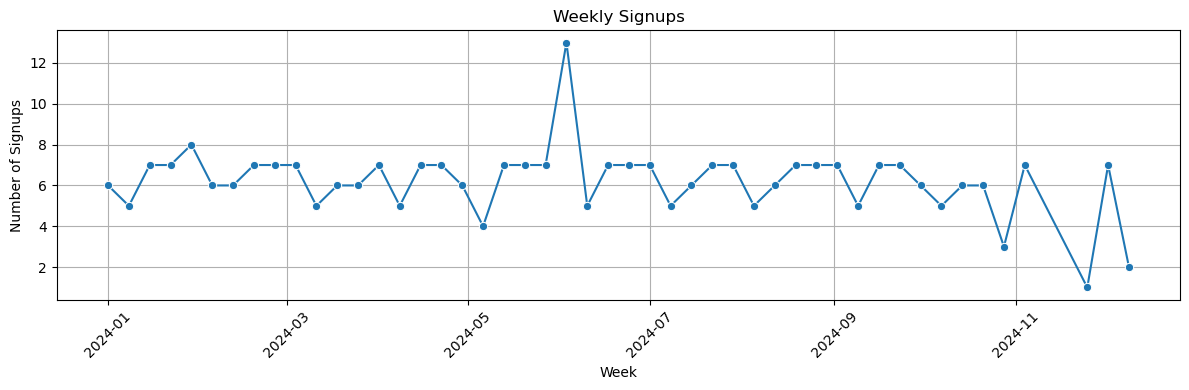

In [21]:
# Sign-ups per week (grouped by signup_date) 
df['signup_week'] = df['signup_date'].dt.to_period('W').apply(lambda r: r.start_time)

# Group by week and count signups
weekly_signups = df.groupby('signup_week').size().reset_index(name='signups')

# Sort by date
weekly_signups = weekly_signups.sort_values('signup_week')

plt.figure(figsize=(12, 4)) 
sns.lineplot(data=weekly_signups, x='signup_week', y='signups', marker='o')
plt.title('Weekly Signups')
plt.xlabel('Week')
plt.ylabel('Number of Signups')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [22]:
weekly_signups

,signup_week,signups
0,2024-01-01,6
1,2024-01-08,5
2,2024-01-15,7
3,2024-01-22,7
4,2024-01-29,8
5,2024-02-05,6
6,2024-02-12,6
7,2024-02-19,7
8,2024-02-26,7
9,2024-03-04,7


      source  signups
0    YouTube       58
1     Google       50
2   Referral       49
3  Instagram       48
4   Facebook       40
5   LinkedIn       38
6    Unknown       15


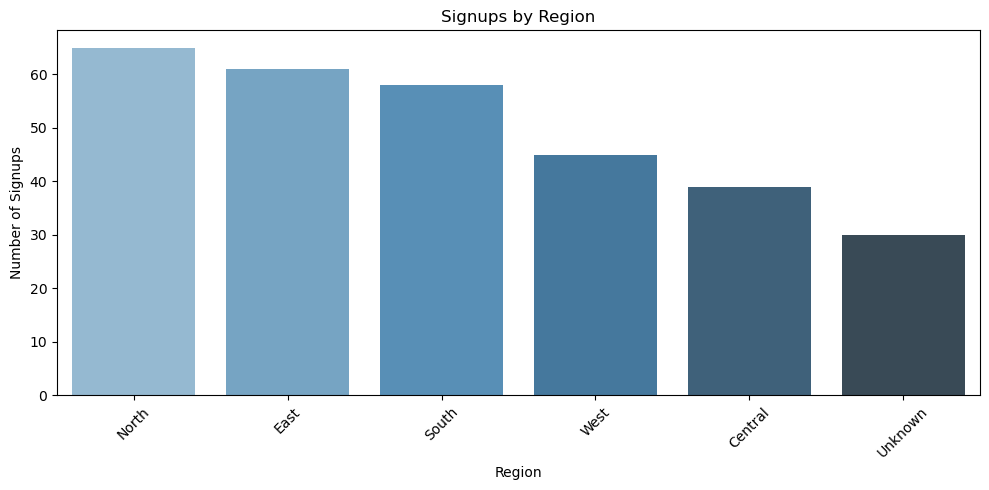

  plan_selected  signups
0       Premium       99
1           Pro       93
2         Basic       92
3   Unknownplan       14


In [23]:
# Sign-ups by source, region, and plan_selected 
signups_by_source = df['source'].value_counts().reset_index(name='signups')
signups_by_source.columns = ['source', 'signups']
print(signups_by_source)

signups_by_region = df['region'].value_counts().reset_index(name='signups')
signups_by_region.columns = ['region', 'signups']

# Sort regions by signups descending
signups_by_region = signups_by_region.sort_values(by='signups', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 5))  # Adjust the size to fit without scrolling
sns.barplot(data=signups_by_region, x='region', y='signups', palette='Blues_d',hue='region',legend=False)

plt.title('Signups by Region')
plt.xlabel('Region')
plt.ylabel('Number of Signups')
plt.xticks(rotation=45)  # Rotate x-axis labels for better fit
plt.tight_layout()       # Prevent clipping
plt.show()

signups_by_plan = df['plan_selected'].value_counts().reset_index(name='signups')
signups_by_plan.columns = ['plan_selected', 'signups']
print(signups_by_plan)


In [24]:
# Marketing opt-in counts by gender 

Marketing_optin_by_gender = df.groupby(['gender', 'marketing_opt_in']).size().reset_index(name='count')
print(Marketing_optin_by_gender)

         gender marketing_opt_in  count
0        Female               No     47
1        Female          Unknown      1
2        Female              Yes     44
3          Male               No     51
4          Male          Unknown      3
5          Male              Yes     37
6         Other               No     52
7         Other          Unknown      6
8         Other              Yes     43
9   Unspecified               No      7
10  Unspecified              Yes      7


In [25]:
# Age summary: min, max, mean, median, null count 
Age_summary= { 
    'Min Age'    : df['age'].min(),
    'Max Age'    : df['age'].max(),
    'Mean  '   : df['age'].mean().round(2),
    'Median' : df['age'].median(),
    'Null Count': df['age'].isna().sum()
            }

Age_summary


{'Min Age': 21,
 'Max Age': 60,
 'Mean  ': 35.55,
 'Median': 34.0,
 'Null Count': 19}

###  4. Answer the business Questions 

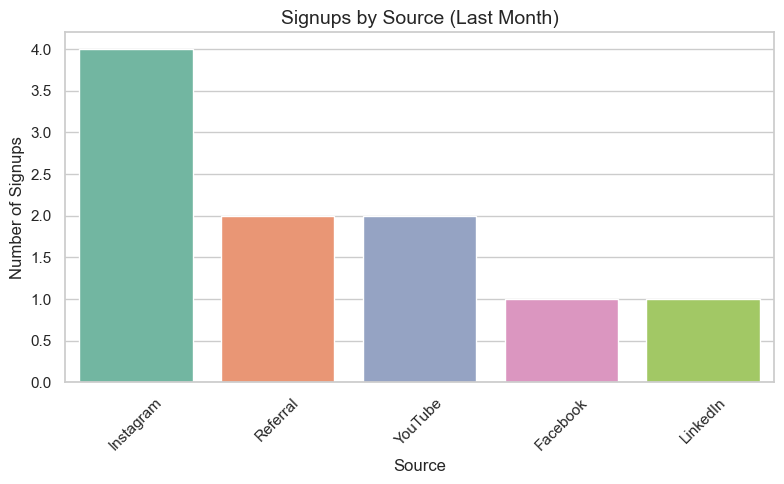

Top acquisition source in December 2024:
Instagram with 4 sign-ups


In [26]:
# Which acquisition source brought in the most users last month? 

last_month_start = pd.Timestamp('2024-12-01')
last_month_end = pd.Timestamp('2024-12-31')

df_last_month = df[(df['signup_date'] >= last_month_start) & 
                   (df['signup_date'] <= last_month_end)]

#count signups by source
source_counts = df_last_month['source'].value_counts()

sns.set(style="whitegrid")

# Prepare the data as a DataFrame (from source_counts Series)
source_df = source_counts.reset_index()
source_df.columns = ['source', 'signups']

# Plot with hue set to x variable and legend off
plt.figure(figsize=(8, 5))
sns.barplot(data=source_df, x='source', y='signups', hue='source', palette='Set2', legend=False)

plt.title("Signups by Source (Last Month)", fontsize=14)
plt.xlabel("Source", fontsize=12)
plt.ylabel("Number of Signups", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

top_source = source_counts.idxmax()
top_signups = source_counts.max()

print(f"Top acquisition source in December 2024:")
print(f"{top_source} with {top_signups} sign-ups")


In [27]:
# Which region shows signs of missing or incomplete data
# Null/Missing values in email id corresponding to each region and % of missing values

df_original['region'] = df_original['region'].fillna('Unknown')
missing_summary = df_original.groupby('region').agg(
    total_users=('email', 'size'),
    missing_emails_count=('email', lambda x: x.isna().sum())
)

missing_summary['%_missing'] = (missing_summary['missing_emails_count'] / missing_summary['total_users']) * 100
missing_summary = missing_summary.reset_index()

missing_summary 

,region,total_users,missing_emails_count,%_missing
0,Central,39,5,12.820513
1,East,61,7,11.475410
2,North,65,10,15.384615
3,South,59,4,6.779661
4,Unknown,30,4,13.333333
5,West,46,4,8.695652


marketing_opt_in  No  Unknown  Yes
age_group                         
18–24             42        4   30
25–34             48        3   39
35–44             25        1   24
45–54             24        2   23
55–64              8        0    6


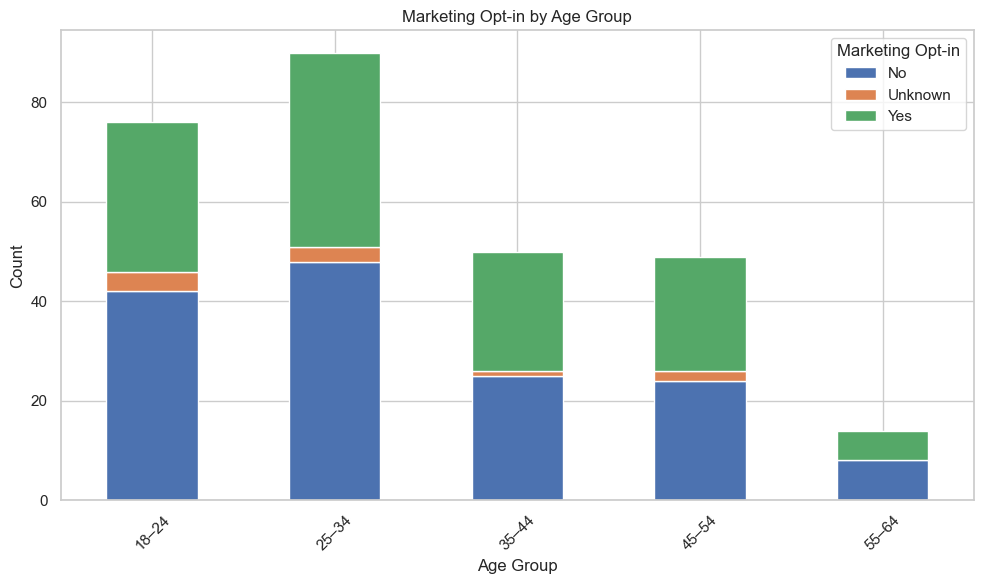

In [28]:
# Are older users more or less likely to opt in to marketing? 

age_bins = [18, 25, 35, 45, 55, 65]
age_labels = ['18–24', '25–34', '35–44', '45–54', '55–64']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)
optin_by_age = df.groupby(['age_group', 'marketing_opt_in'],observed=True).size().unstack(fill_value=0)

optin_by_age.plot(kind='bar', stacked=True, figsize=(10,6))
print(optin_by_age)
plt.title('Marketing Opt-in by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Marketing Opt-in')
plt.tight_layout()
plt.show()

In [29]:
# Which plan is most commonly selected, and by which age group? 
most_common_plan_by_age = (
    df.groupby('age_group',observed=True)['plan_selected']
    .agg(lambda x: x.mode().iloc[0])  # mode = most common
    .reset_index(name='most_common_plan')
)
most_common_plan_by_age 

,age_group,most_common_plan
0,18–24,Basic
1,25–34,Premium
2,35–44,Premium
3,45–54,Pro
4,55–64,Basic


### 5. Optional Stretch Task 

In [30]:
# Load the support_tickets.csv dataset 
df_support_tickets = pd.read_csv('support_tickets.csv', encoding='unicode_escape')
df_support_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ticket_id    123 non-null    object
 1   customer_id  123 non-null    object
 2   ticket_date  123 non-null    object
 3   issue_type   123 non-null    object
 4   resolved     123 non-null    object
dtypes: object(5)
memory usage: 4.9+ KB


In [31]:
# Join support_tickets to customer_signups.csv on customer_id 

# converting object type date to datetime to make use of date functions
df_support_tickets['ticket_date'] = pd.to_datetime(df_support_tickets['ticket_date'])

# Merge both DataFrames on customer_id
df_merged = pd.merge(df, df_support_tickets, on='customer_id', how='inner')
df_merged.head(100)

,customer_id,name,email,signup_date,source,region,plan_selected,marketing_opt_in,age,gender,signup_week,age_group,ticket_id,ticket_date,issue_type,resolved
0,CUST00005,John Gonzales,john5@mailhub.org,2024-06-01,Facebook,South,Premium,No,34,Other,2024-05-27,25–34,TKT0008-1,2024-06-04,Other,Yes
1,CUST00007,Michael Bailey,michael7@mailhub.org,2024-08-01,YouTube,Central,Pro,Yes,60,Other,2024-07-29,55–64,TKT0036-1,2024-08-07,Billing,Yes
2,CUST00007,Michael Bailey,michael7@mailhub.org,2024-08-01,YouTube,Central,Pro,Yes,60,Other,2024-07-29,55–64,TKT0036-2,2024-08-23,Other,Yes
3,CUST00009,Cindy Anderson,unknown@example.com,2024-10-01,Google,East,Premium,No,29,Female,2024-09-30,25–34,TKT0003-1,2024-10-03,Technical Error,No
4,CUST00017,Patty Paul,patty17@inboxmail.net,2024-01-18,YouTube,East,Pro,No,53,Other,2024-01-15,45–54,TKT0030-1,2024-02-03,Other,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,CUST00237,Olivia Schmitt,olivia37@example.com,2024-08-25,Facebook,East,Pro,No,34,Female,2024-08-19,25–34,TKT0010-1,2024-09-15,Account Setup,Yes
96,CUST00237,Olivia Schmitt,olivia37@example.com,2024-08-25,Facebook,East,Pro,No,34,Female,2024-08-19,25–34,TKT0010-2,2024-09-23,Other,Yes
97,CUST00237,Olivia Schmitt,olivia37@example.com,2024-08-25,Facebook,East,Pro,No,34,Female,2024-08-19,25–34,TKT0010-3,2024-09-19,Login Issue,Yes
98,CUST00238,Misty Blair,misty38@example.com,2024-08-26,Instagram,West,Premium,Yes,53,Male,2024-08-26,45–54,TKT0029-1,2024-08-30,Login Issue,Yes


In [32]:
# Count how many customers contacted support within 2 weeks of sign-up 

# Calculate difference in days between ticket and signup
df_merged['days_since_signup'] = (df_merged['ticket_date'] - df_merged['signup_date']).dt.days

# Filter where the support ticket came within 14 days
within_2_weeks = df_merged[df_merged['days_since_signup'].between(0, 14)]

# Count unique customers who contacted support within 2 weeks
count = within_2_weeks['customer_id'].nunique()

print(f"Number of customers who contacted support within 2 weeks: {count}")


Number of customers who contacted support within 2 weeks: 47


In [33]:
# Summarise support activity by plan and region (Group by plan and region)

support_summary = df_merged.groupby(['plan_selected', 'region']).agg(
    total_tickets=('ticket_date', 'count'),
    unique_customers=('customer_id', 'nunique')
).reset_index()

# Sort by total_tickets and then by unique_customers (both descending)
support_summary = support_summary.sort_values(
    by=['total_tickets', 'unique_customers'], ascending=[False, False]
)

print(support_summary)

   plan_selected   region  total_tickets  unique_customers
3          Basic    South             14                 6
12           Pro     East             14                 6
1          Basic     East             11                 6
13           Pro    North             11                 6
10       Premium     West             11                 5
11           Pro  Central             10                 5
5          Basic     West             10                 4
16           Pro     West              6                 4
18   Unknownplan    North              6                 3
6        Premium  Central              6                 2
8        Premium    North              6                 2
2          Basic    North              3                 2
14           Pro    South              3                 2
15           Pro  Unknown              3                 1
9        Premium    South              2                 2
0          Basic  Central              2                

In [41]:
# (Optional) Which plan’s users are most likely to contact support? 
plan_wise_customer_summary = df.groupby(['plan_selected'])['customer_id'].nunique()

plan_wise_support_summary = df_merged.groupby(['plan_selected'])['customer_id'].nunique()

contact_summary = (plan_wise_support_summary*100/plan_wise_customer_summary).reset_index(name='contact_rate')
contact_summary = contact_summary.sort_values(by = 'contact_rate',ascending = False ).reset_index(drop=True)


contact_summary.round(2)

,plan_selected,contact_rate
0,Unknownplan,28.57
1,Pro,25.81
2,Basic,21.74
3,Premium,12.12


### Additional Analysis

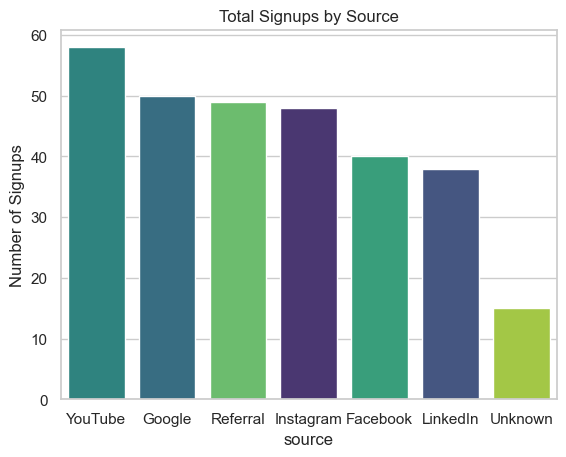

In [35]:
# source counts
sns.countplot(data=df,hue='source',legend=False,x='source',order=df['source'].value_counts().index, palette='viridis')
plt.title('Total Signups by Source')
plt.xlabel('source')
plt.ylabel('Number of Signups')
plt.show()

In [36]:
# Most common source by age group
source_counts_byage = (
    df.groupby(['age_group','source'],observed=True).size().reset_index(name='source_counts')
)

max_sources = source_counts_byage[
    source_counts_byage['source_counts'] == source_counts_byage.groupby('age_group',observed=True)['source_counts']
.transform('max')
]
max_sources.columns = ['age_group', 'source' ,'max_source_counts']

max_sources = max_sources.sort_values(by='max_source_counts',ascending=False).reset_index(drop=True)
max_sources


,age_group,source,max_source_counts
0,25–34,Google,22
1,18–24,LinkedIn,18
2,18–24,YouTube,18
3,35–44,YouTube,15
4,45–54,Instagram,10
5,55–64,YouTube,6


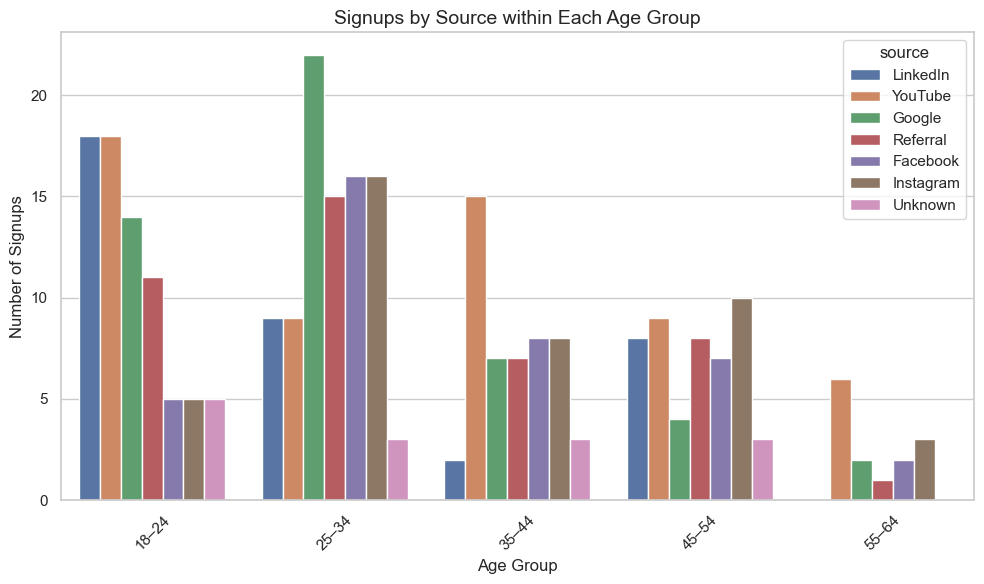

In [37]:
# Sort data within each age_group by source_counts
sorted_df = source_counts_byage.sort_values(['age_group', 'source_counts'], ascending=[True, False])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=sorted_df,
    x='age_group',
    y='source_counts',
    hue='source'
 #   palette=sns.color_palette("BuGn")
)

plt.title("Signups by Source within Each Age Group", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Number of Signups", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

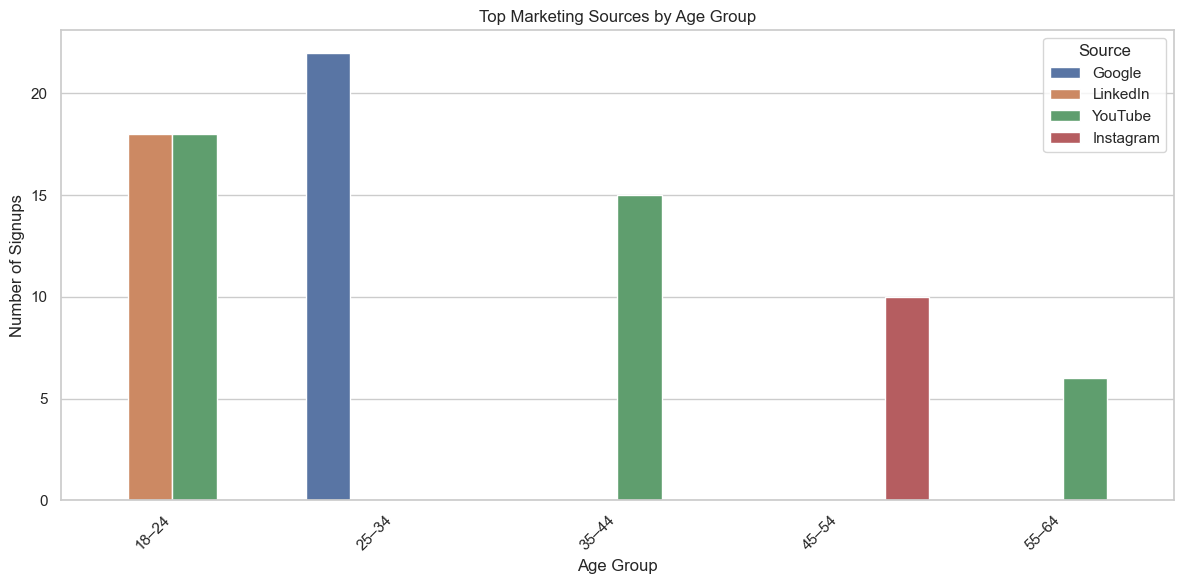

In [38]:
plt.figure(figsize=(12,6))
sns.barplot(data=max_sources, x='age_group', y='max_source_counts', hue='source')
plt.title('Top Marketing Sources by Age Group')
plt.ylabel('Number of Signups')
plt.xlabel('Age Group')
plt.legend(title='Source')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

In [39]:
optin_by_age = df.groupby(['age_group', 'marketing_opt_in'],observed=True).size().unstack(fill_value=0)
optin_by_age

marketing_opt_in,No,Unknown,Yes
age_group,,,
18–24,42,4,30
25–34,48,3,39
35–44,25,1,24
45–54,24,2,23
55–64,8,0,6
